In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch_optimizer as optim

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import time
import matplotlib.pyplot as plt
import torchvision.ops

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exe_file = "/mnt/ssd1/nyh/AI_Competition"

/home/eslab/anaconda3/envs/nyh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# train_img_shape = (1024, 1024)
train_img_shape = (256, 256)
train_resize_img_shape = (224, 224)
valid_img_shape = (224, 224)
test_img_shape = (224, 224)
batch_size = 64
threshold = 0.6
random_seed = 20230705
loss_func = [["DICE",0.8], ["FOCAL",0.2]] # first = DICE, second = FOCAL
model = smp.UnetPlusPlus
# model = smp.Unet
# model = smp.DeepLabV3
# model_name = ["timm-efficientnet-b4","noisy-student"]
# model_name = ["dpn92","imagenet+5k"]
model_name = ["se_resnext101_32x4d","imagenet"]
optimizer_name = "RAdam"

In [4]:
def random_seed_func(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

In [5]:
cpu_core_num = os.cpu_count()
gpu_num = torch.cuda.device_count()

print(f"{cpu_core_num} cpu cores")
print("Let's use", torch.cuda.device_count(), "GPUs!")

36 cpu cores
Let's use 4 GPUs!


## Utils
- https://dacon.io/competitions/official/236092/talkboard/408732?page=1&dtype=recent


In [6]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    '''
    Calculate Dice Score between two binary masks.
    '''
    scores = []
    for i in range(prediction.shape[0]):
        intersection = np.sum(prediction[i] * ground_truth[i])
        score = (2.0 * intersection + smooth) / (np.sum(prediction[i]) + np.sum(ground_truth[i]) + smooth)

        scores.append(score)

    scores = sum(scores)/prediction.shape[0]
    return scores


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)):
    print(ground_truth_df.shape, prediction_df.shape)

    # Find the indices where the prediction ids exist in the ground truth ids
    prediction_ids = prediction_df.tolist()
    ground_truth_ids = ground_truth_df.tolist()
    matching_indices = [i for i in range(len(prediction_ids)) if prediction_ids[i] in ground_truth_ids]

    # Filter the prediction and ground truth dataframes based on the matching indices
    prediction_df = prediction_df[matching_indices]
    ground_truth_df = ground_truth_df[matching_indices]

    # # Extract the mask_rle columns
    print(ground_truth_df.shape, prediction_df.shape)
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df
    # pred_mask_rle = prediction_df[:, 0, :, :].squeeze(0)
    # gt_mask_rle = ground_truth_df.squeeze(0)

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None

    dice_scores = []
    for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle):
        dice_score = calculate_dice(pred_rle, gt_rle)
        # print(dice_score)
        if dice_score is not None:
            dice_scores.append(dice_score)

    return np.mean(dice_scores)

In [7]:
# RLE 디코딩 함수

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, mode = None, transform=None, infer=False):
        
        self.data = pd.read_csv(csv_file)
        self.mode = mode # index number // Train_test_split
        self.transform = transform
        self.infer = infer

        if mode is not None:
            self.data = self.data.loc[self.mode]
        # self.data = self.data.reset_index()
        # print(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        img_path = self.data.iloc[idx, 1]
        # img_path = img_path.split(".")

        # print(img_path)
        # img_path = exe_file + img_path[0] + img_path[1] + ".png"
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            img_path = img_path.split(".")
            img_path = exe_file + img_path[0] + img_path[1] + ".png"
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # print(img_path)
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_rle)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [9]:
# model = smp.UnetPlusPlus(classes=2,
#                 encoder_name="timm-efficientnet-b4",
#                 encoder_weights="noisy-student",
#                ).to(device)
# model.load_state_dict(torch.load("./best_timm_efficientnet_b4_val_86.9483.pt")['model_state_dict'])

# model = smp.UnetPlusPlus(classes=2,
#                 encoder_name="timm-efficientnet-b3",
#                 encoder_weights="noisy-student",
#                ).to(device)
# model.load_state_dict(torch.load("./best_timm_efficientnet_b3_val_87.28.pt")['model_state_dict'])

# model = smp.Unet(classes=2,
#                 encoder_name="resnet18",
#                 encoder_weights="imagenet",
#                ).to(device)
# model.load_state_dict(torch.load("../best_resnet18_88.4916.pt")['model_state_dict'])


model = smp.UnetPlusPlus(classes=2,
                encoder_name="se_resnext101_32x4d",
                encoder_weights="imagenet",
               ).to(device)
# model.load_state_dict(torch.load("./best_se_resnext101_32x4d_pretrained_1024_1024_89.34.pt")['model_state_dict'])
model.load_state_dict(torch.load("./best_se_resnext101_32x4d_val_87.14_(81.8).pt")['model_state_dict'])

model2 = smp.UnetPlusPlus(classes=2,
                encoder_name="se_resnext50_32x4d",
                encoder_weights="imagenet",
                in_channels=4
               ).to(device)
model2.load_state_dict(torch.load("./best_se_resnext50_32x4d_boundry_plus_0.14.pt")['model_state_dict'])


<All keys matched successfully>

884


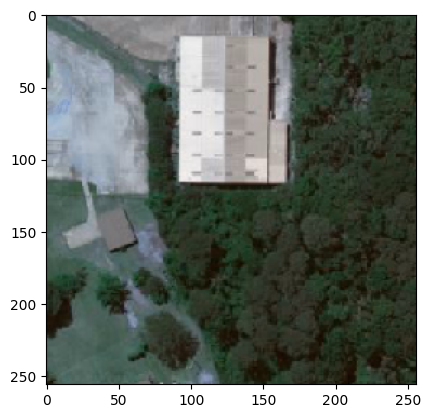

In [10]:
csv_path = "/mnt/ssd1/nyh/AI_Competition/train_csv.csv"

img_number = "0055"
sub_img_number = "1_0"

idx = (int(img_number)+1) * 16 - 4* (3 - int(sub_img_number[0])) - (4 - int(sub_img_number[2]))
print(idx)
data = pd.read_csv(csv_path)
img_path = data.iloc[idx, 1]
input_img = cv2.imread(img_path)
plt.imshow(input_img)

In [11]:
train_transform = A.Compose(
    [   
        A.Resize(train_img_shape[0], train_img_shape[1]),
        ToTensorV2()
    ]

)
train_dataset = SatelliteDataset(csv_file=csv_path , mode = [idx], transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

In [12]:
print(train_dataloader.__len__())

1


In [13]:
def model_forward(model, images, threshold):#mask를 통과하고 threshold를 통과시켜주는 것
    output = model(images.float().to(device)).mean(axis = 1)
    masks = torch.sigmoid(output).cpu().detach().numpy()
    masks = (masks > threshold).astype(np.uint8) # Threshold = 0.35
    return masks

In [14]:
def make_boundary(output_masks, mp_size):
    dst = cv2.dilate(output_masks, cv2.getStructuringElement(cv2.MORPH_RECT, (mp_size[0], mp_size[1])))
    diff_clamped = torch.clamp(torch.Tensor(dst)- torch.Tensor(output_masks), min=0, max=1) # 팽창 - 원본 => 경계
    return diff_clamped

In [15]:
def coordinate_calibration(indices, img_crop, calibration = True):

    if calibration: xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=256-img_crop), torch.clamp(indices[1] - img_crop//2, min=0, max=256-img_crop)
    else: xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=256), torch.clamp(indices[1] - img_crop//2, min=0, max=256)

    boundary_mask = [torch.stack([x, y, x+img_crop, y+img_crop]) for x, y in zip(xx, yy)]
    boundary_mask = torch.stack(boundary_mask)
    return boundary_mask

In [17]:
# red_boundary = np.zeros_like(masks_pred)
# red_boundary[diff_clamped[:, :, 0] > 0] = [255, 0, 0]
def make_red_boundary(masks_pred, diff_clamped):
    red_boundary = np.zeros_like(masks_pred)
    red_boundary[diff_clamped[:, :, 0] > 0] = [255, 0, 0]
    return red_boundary

torch.Size([1, 3, 256, 256])
(256, 256, 3) torch.Size([256, 256, 3]) S
(1, 256, 256)
print(masks.shape) (256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([22, 4, 32, 32]) (22, 32, 32)


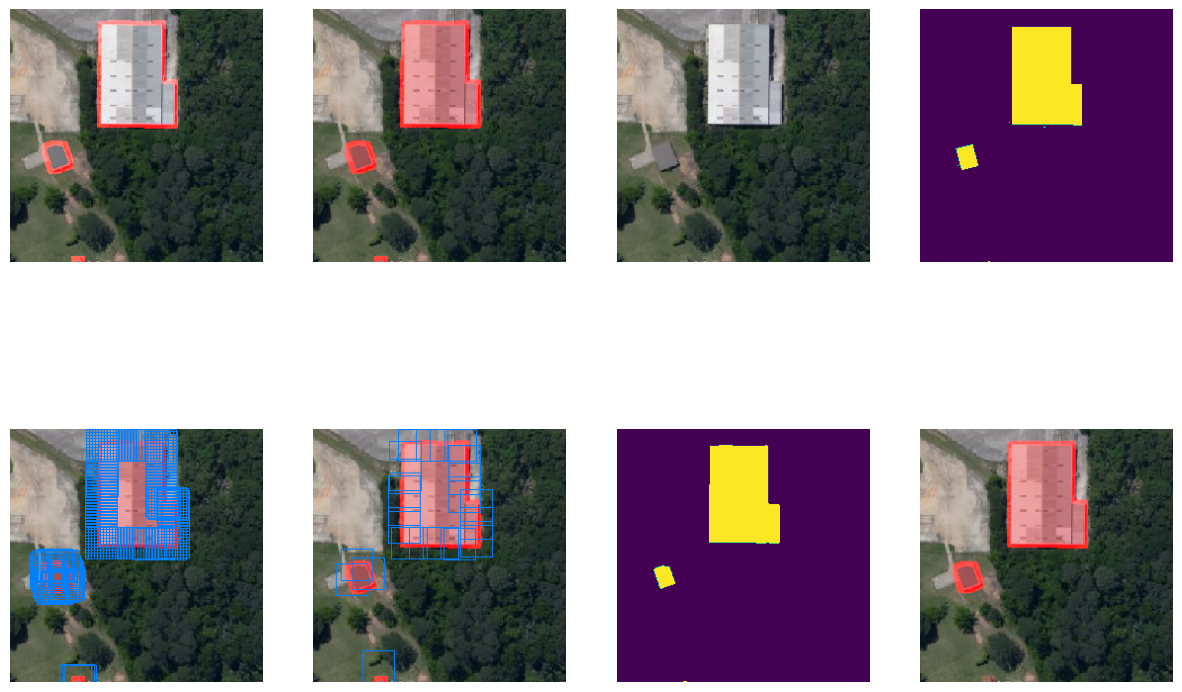

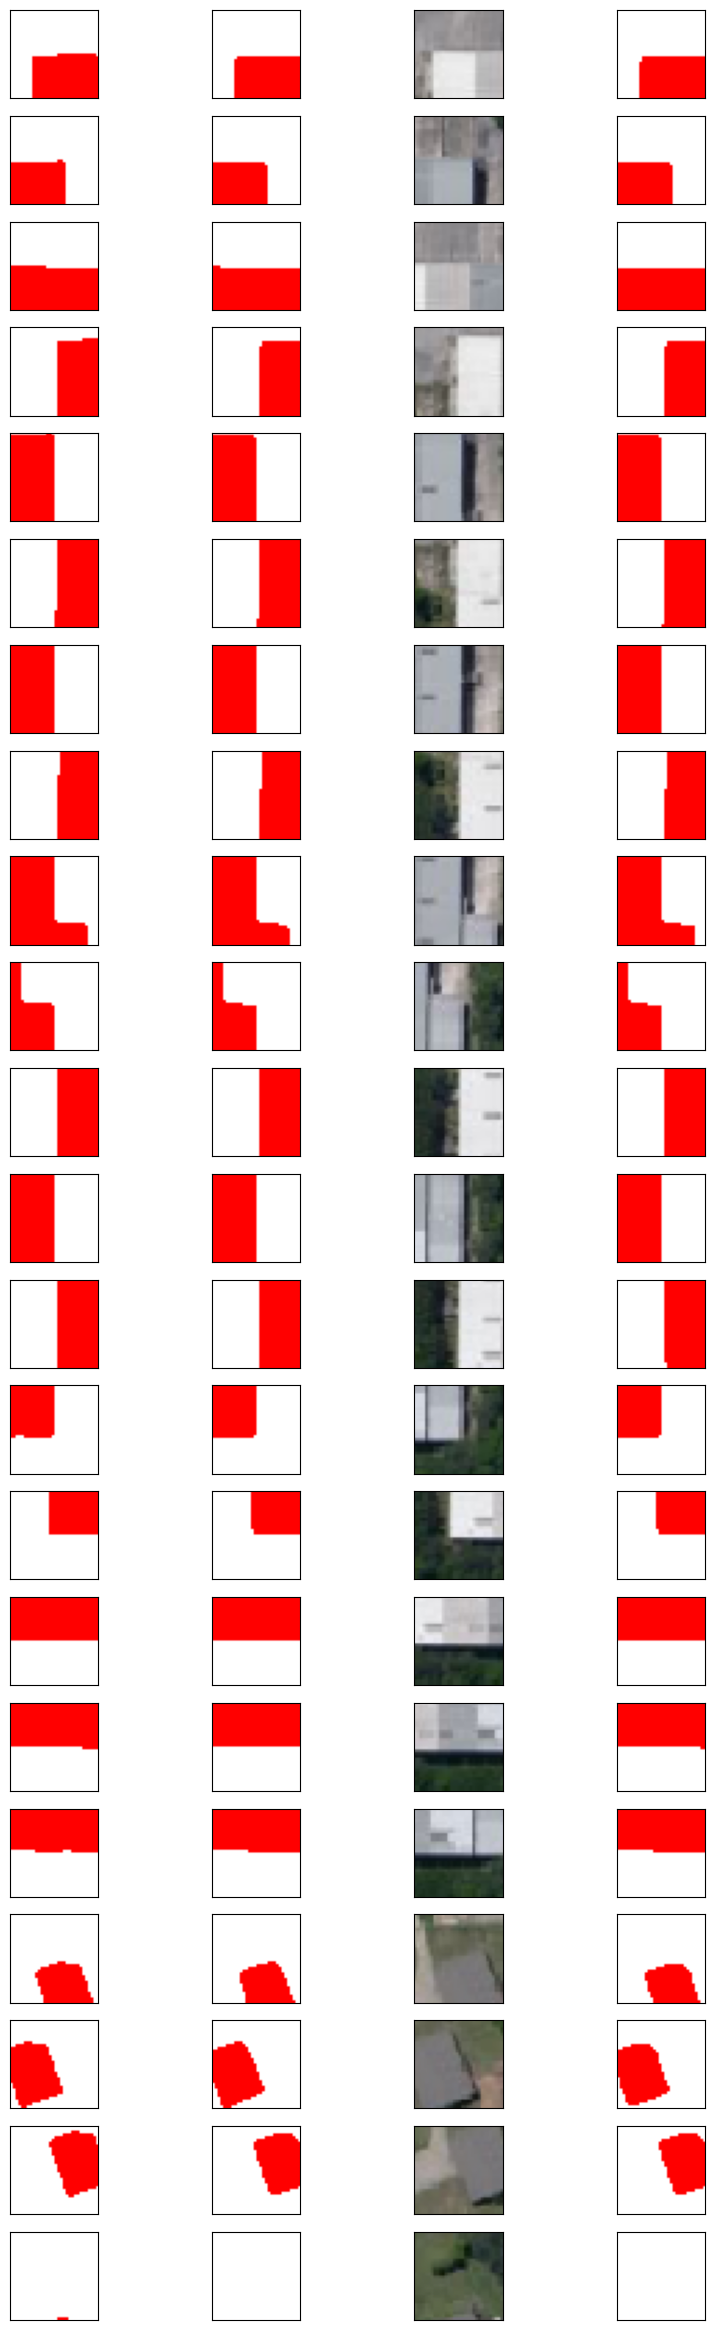

In [18]:
img_crop = 32

row_num, col_num = 2, 4
fig, axes = plt.subplots(row_num, col_num, figsize=(15, 10))

for images, label in train_dataloader:
    print(images.shape)
    np_img = images.squeeze().permute(1,2,0).numpy()

    masks = model_forward(model, images, threshold)

    crop_32_input, crop_32_gt, crop_32_gt_info = [], [], []
    for i, img in enumerate(masks):
        output_masks = img.copy()
        output_masks = cv2.cvtColor(output_masks, cv2.COLOR_GRAY2RGB)
        
        diff_clamped = make_boundary(output_masks, mp_size=(11,11))
        

        # 빨간색 경계선 생성

        print(output_masks.shape, diff_clamped.shape, "S")
        red_boundary = np.zeros_like(output_masks)
        red_boundary[diff_clamped[:, :, 0] > 0] = [255, 0, 0]

        overlay = np.where(red_boundary > 0, red_boundary, np_img)

        ax = plt.subplot(row_num, col_num, 1)
        ax.imshow(overlay)
        ax.axis('off')


        # Identifying and filling inside the boundary
        contours, hierarchy = cv2.findContours(diff_clamped.numpy().astype(np.uint8)[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_area = np.zeros_like(diff_clamped)
        cv2.drawContours(filled_area, contours, -1, (1, 0, 0), thickness=-1)

        transparent_red = [255, 0, 0, 0.3]
        overlay_transparent = np.where(filled_area[:, :, 0][:, :, np.newaxis] > 0, transparent_red[:3], overlay)
        alpha = transparent_red[3]
        final_overlay = (overlay_transparent * alpha + np_img * (1 - alpha)).astype(np.uint8)
        real_overlay = np.where(red_boundary > 0, red_boundary, final_overlay)

        ax = plt.subplot(row_num, col_num, 2)
        ax.imshow(real_overlay)
        ax.axis('off')

        ax = plt.subplot(row_num, col_num, 3)
        ax.imshow(np_img)
        ax.axis('off')

        ax = plt.subplot(row_num, col_num, 4)
        ax.imshow(label.squeeze())
        ax.axis('off')

        diff_clamped = make_boundary(img, mp_size=(3,3))


        indices = torch.where(diff_clamped == 1) # [Row, Col]

        
        overlay_nms_o, overlay_nms_x = real_overlay.copy(), real_overlay.copy()

        boundary_mask = coordinate_calibration(indices, img_crop, calibration = False)
        boundary_mask_output_nms_x = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.85)

        for x, y, _, _ in  boundary_mask[boundary_mask_output_nms_x]:
            output_image_nms_x = cv2.rectangle(overlay_nms_x, (y.item(), x.item()), (y.item()+img_crop, x.item()+img_crop), (0, 128, 255), 1) # 하늘색으로 패치 그리기

        boundary_mask = coordinate_calibration(indices, img_crop, calibration = True)
        boundary_mask_output_nms_o = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.3)

        for x, y, _, _ in  boundary_mask[boundary_mask_output_nms_o]:
            crop_32_input.append(torch.cat([images[i, :, x:x+img_crop, y:y+img_crop], torch.Tensor(masks[i, x:x+img_crop, y:y+img_crop].reshape(1, img_crop, img_crop))], axis = 0)) # 입력 이미지 차원 [(B+num), 4, 32, 32]
            crop_32_gt_info.append([i,x,y])
            crop_32_gt.append(masks[i, x:x+img_crop, y:y+img_crop]) # 정답 차원 [(B+num), 32,32]
            output_image_nms_o = cv2.rectangle(overlay_nms_o, (y.item(), x.item()), (y.item()+img_crop, x.item()+img_crop), (0, 128, 255), 1) # 하늘색으로 패치 그리기
        
    ax = plt.subplot(row_num, col_num, 5)
    ax.imshow(output_image_nms_x)
    ax.axis('off')

    ax = plt.subplot(row_num, col_num, 6)
    ax.imshow(output_image_nms_o)
    ax.axis('off')

    crop_32_input = torch.stack(crop_32_input)
    crop_32_input = crop_32_input.to(device)

    pred_32_mask = model_forward(model2, crop_32_input, threshold)
    
    ax = plt.subplot(row_num, col_num, 7)
    ax.imshow(masks.squeeze())
    ax.axis('off')



    for (batch_num_idx, idx_x, idx_y), pred_32_mask_one in zip(crop_32_gt_info, pred_32_mask):
        masks[batch_num_idx, idx_x:idx_x+img_crop, idx_y:idx_y+img_crop] = pred_32_mask_one

    ax = plt.subplot(row_num, col_num, 8)
    ax.imshow(masks.squeeze())
    ax.axis('off')
    
    print(masks.shape)
    masks_pred = cv2.cvtColor(masks.squeeze(), cv2.COLOR_GRAY2RGB)
    print("print(masks.shape)", masks_pred.shape)
    # dst = cv2.dilate(masks_pred, cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))) # 모폴로지 팽창 연산
    
    diff_clamped = make_boundary(masks_pred, (11,11)) # 팽창 - 원본 => 경계
    indices = torch.where(diff_clamped == 1) # [Row, Col]
    
    #mask boundary

    
    red_boundary = make_red_boundary(masks_pred, diff_clamped)
    overlay_pred = np.where(red_boundary > 0, red_boundary, np_img)

    # Identifying and filling inside the boundary
    contours, hierarchy = cv2.findContours(diff_clamped.numpy().astype(np.uint8)[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_area = np.zeros_like(diff_clamped)
    cv2.drawContours(filled_area, contours, -1, (1, 0, 0), thickness=-1)

    transparent_red = [255, 0, 0, 0.3]
    overlay_transparent = np.where(filled_area[:, :, 0][:, :, np.newaxis] > 0, transparent_red[:3], overlay)
    alpha = transparent_red[3]
    final_overlay = (overlay_transparent * alpha + np_img * (1 - alpha)).astype(np.uint8)
    real_overlay = np.where(red_boundary > 0, red_boundary, final_overlay)
    plt.imshow(real_overlay)
        
    break

row_num, col_num = 22, 4
fig, axes = plt.subplots(row_num, col_num, figsize=(10, 30))

print(crop_32_input.shape, pred_32_mask.shape)

i = 1
for ori, pred, gt in zip(crop_32_input, pred_32_mask, crop_32_gt):
    # print(ori.shape, pred.shape)
    img_ori = ori[0:3, :, :].permute(1,2,0).cpu().detach().numpy().astype(np.uint8)
    ori = ori[-1, :, :].squeeze().cpu().detach().numpy()

    ori = cv2.cvtColor(ori, cv2.COLOR_GRAY2RGB) 
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    gt = cv2.cvtColor(gt, cv2.COLOR_GRAY2RGB)

    ori[ori[:, :, 0] > 0] = [0, 255, 255]
    pred[pred[:, :, 0] > 0] = [0, 255, 255]
    gt[gt[:, :, 0] > 0] = [0, 255, 255]

    ori = 255-ori
    pred = 255 - pred
    gt = 255 - gt

    ax = plt.subplot(row_num, col_num, i)
    ax.imshow(ori)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

    ax = plt.subplot(row_num, col_num, i+1)
    ax.imshow(pred)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

    ax = plt.subplot(row_num, col_num, i+2)
    ax.imshow(img_ori)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    # ax.axis('off')

    ax = plt.subplot(row_num, col_num, i+3)
    ax.imshow(gt)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    # ax.axis('off')


    i+=4